1) Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

2) Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

3) Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

4) Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

5) Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

6) Estimate a bounding box for vehicles detected.


In [3]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#import matplotlib.image as mpimg
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from collections import deque

In [2]:
%matplotlib inline

## Collect statistics about the input data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


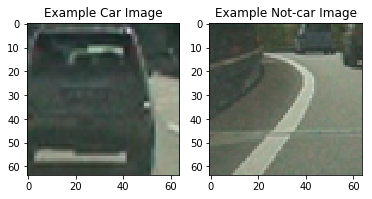

In [4]:
cars = glob.glob('C:/vehicle_training/vehicles/**/*.png', recursive=True)
notcars = glob.glob('C:/vehicle_training/non-vehicles/**/*.png', recursive=True)

# cars = glob.glob('C:/vehicle_training/vehicles_smallset/**/*.jpeg', recursive=True)
# notcars = glob.glob('C:/vehicle_training/non-vehicles_smallset/**/*.jpeg', recursive=True)


# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = cv2.imread(car_list[0])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict


data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:',
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.imread(notcars[notcar_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)

training_image_shape = car_image.shape

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Extract HOG and color features and train a classifier

In [5]:

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    features = hog(img, orientations=orient,
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block),
                   transform_sqrt=True,
                   visualise=vis, feature_vector=feature_vec)
    return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
    
    
def convert_color(image, color_space):
    if color_space == 'RGB':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        
    assert feature_image.dtype == np.uint8
    return feature_image


def get_feature_vector(feature_image, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block):
    file_features = []
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    file_features.append(spatial_features)
    hist_features = color_hist(feature_image, nbins=hist_bins)
    file_features.append(hist_features)
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:, :, channel],
                                             orient, pix_per_cell, cell_per_block,
                                             vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
    file_features.append(hog_features)
        
    return np.concatenate(file_features)


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = convert_color(image, color_space)
        feature_vector = get_feature_vector(feature_image, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
            
        features.append(feature_vector)
    return features

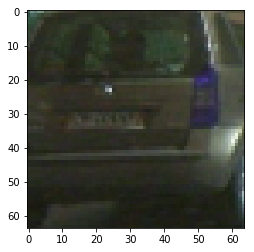

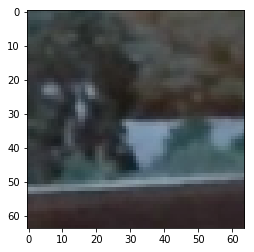

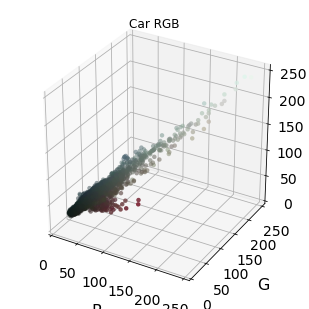

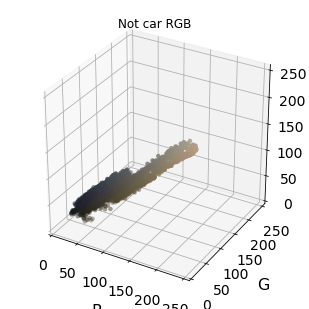

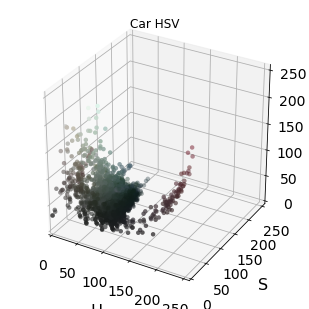

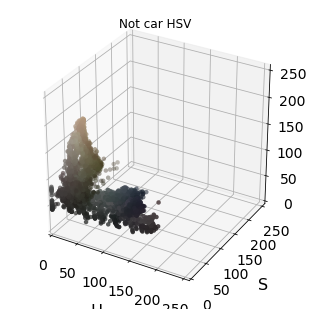

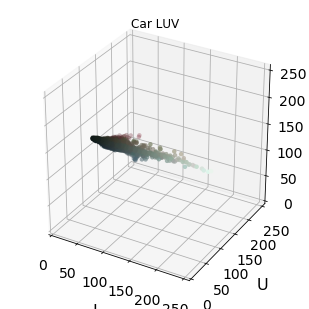

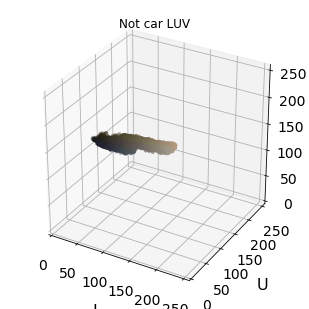

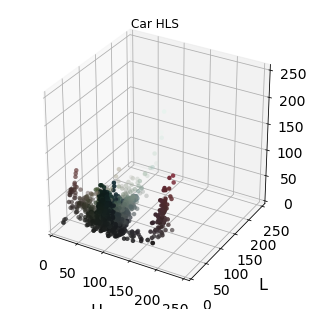

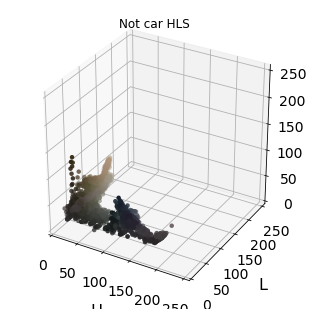

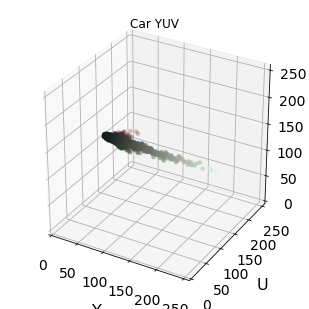

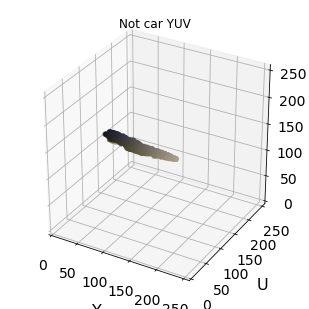

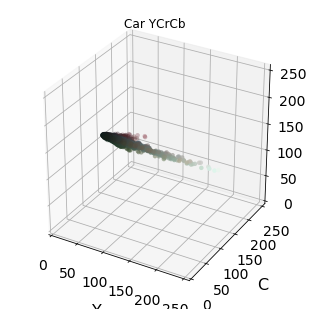

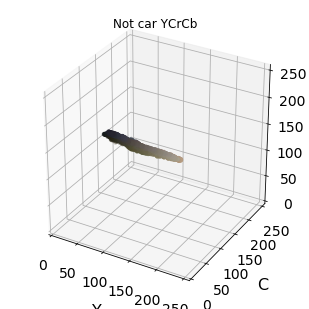

In [5]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(4, 4))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])

plt.imshow(car_image)
plt.show()
plt.imshow(notcar_image)
plt.show()

for cspace in ("RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"):
    car_img_cspace = convert_color(car_image, cspace)
    ax = plot3d(car_img_cspace, convert_color(car_image, "RGB")/255., axis_labels=list(cspace))
    ax.set_title("Car %s" % cspace)
    plt.show()

    notcar_img_cspace = convert_color(notcar_image, cspace)
    ax = plot3d(notcar_img_cspace, convert_color(notcar_image, "RGB")/255., axis_labels=list(cspace))  
    ax.set_title("Not car %s" % cspace)
    plt.show()

C:\Users\steph\Anaconda3\envs\carnd-term1org\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


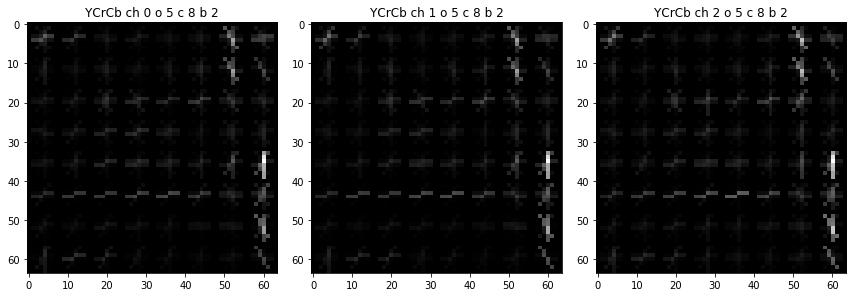

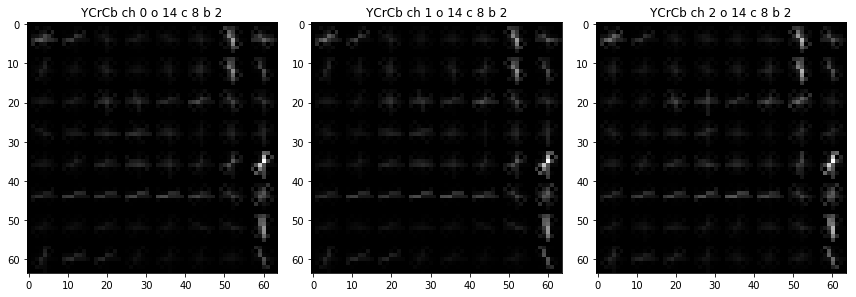

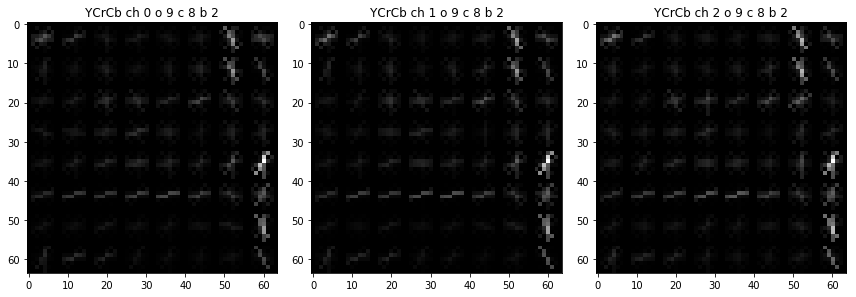

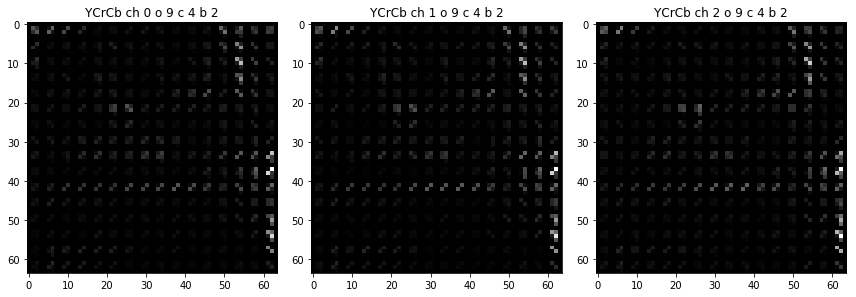

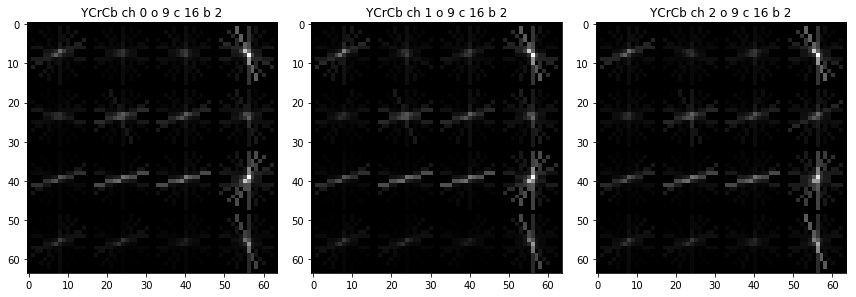

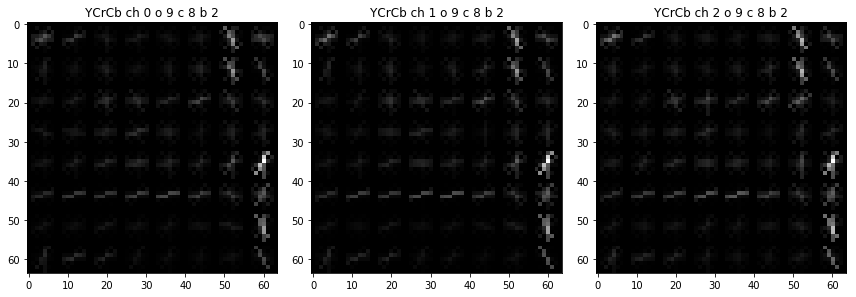

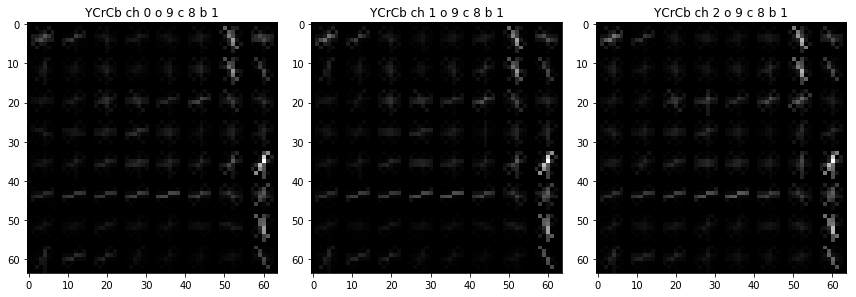

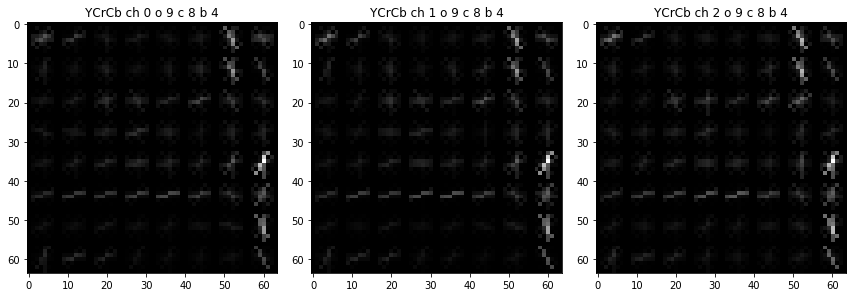

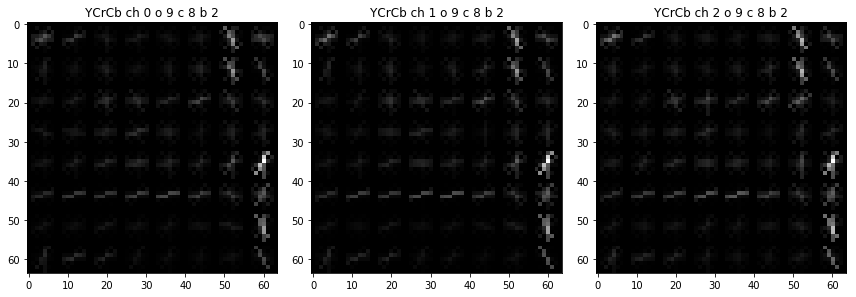

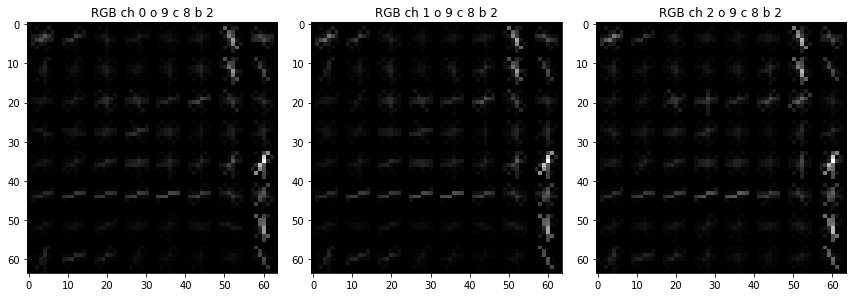

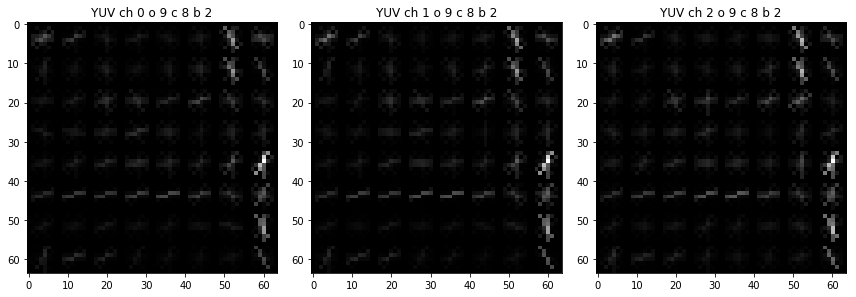

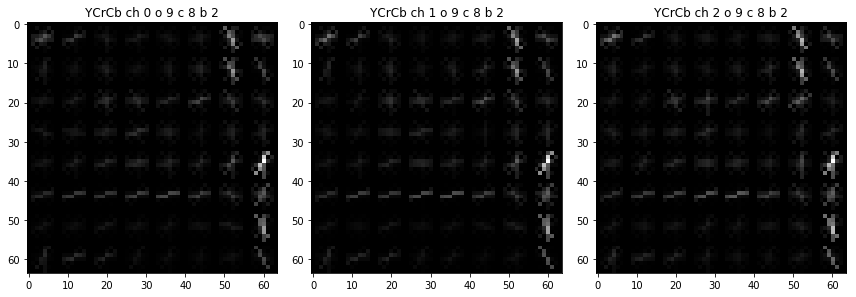

In [6]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
    
for orient in (5,14,9):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
    car_img_cspace = convert_color(car_image, cspace)
    for ch in range(3):
        features, hog_image = hog(car_image[:,:,ch], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)

        ax[ch].imshow(hog_image, cmap="gray")
        ax[ch].set_title('%s ch %s o %s c %s b %s' % (cspace, ch, orient, pix_per_cell, cell_per_block))

    fig.tight_layout()
    
for pix_per_cell in (4,16,8):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
    car_img_cspace = convert_color(car_image, cspace)
    for ch in range(3):
        features, hog_image = hog(car_image[:,:,ch], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)

        ax[ch].imshow(hog_image, cmap="gray")
        ax[ch].set_title('%s ch %s o %s c %s b %s' % (cspace, ch, orient, pix_per_cell, cell_per_block))

    fig.tight_layout()
    
for cell_per_block in (1,4,2):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
    car_img_cspace = convert_color(car_image, cspace)
    for ch in range(3):
        features, hog_image = hog(car_image[:,:,ch], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)

        ax[ch].imshow(hog_image, cmap="gray")
        ax[ch].set_title('%s ch %s o %s c %s b %s' % (cspace, ch, orient, pix_per_cell, cell_per_block))

    fig.tight_layout() 
    
for cspace in ("RGB", "YUV", "YCrCb"):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
    car_img_cspace = convert_color(car_image, cspace)
    for ch in range(3):
        features, hog_image = hog(car_image[:,:,ch], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)

        ax[ch].imshow(hog_image, cmap="gray")
        ax[ch].set_title('%s ch %s o %s c %s b %s' % (cspace, ch, orient, pix_per_cell, cell_per_block))

    fig.tight_layout()

In [6]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = 64
    window = training_image_shape[0]
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg_size = (64,64)
            subimg_size = training_image_shape[:2]
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], subimg_size)
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                box_list.append(box)
                
    return box_list


def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)

    return img


def get_heat_map(image, box_list, threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    return labels, heatmap


    

In [7]:
color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins

In [16]:

t1 = time.monotonic()
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                )
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   )
d1 = time.monotonic() - t1
print("%s seconds to extract features: %s cars, %s not-cars" % (d1, len(car_features), len(notcar_features)))

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)


C:\Users\steph\Anaconda3\envs\carnd-term1org\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


72.95300000000134 seconds to extract features: 8792 cars, 8968 not-cars


In [17]:
print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
18.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9918


In [18]:
# brute force parameter selection

ystart = 400
ystop = 656
scale = 1 # 1.5
treshhold = 1
scales = [0.5, 1, 1.5, 2.0]
scales = [1.5]


color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins

config_id = 0

# for color_space in ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]:
# for orient in [5,7,9,11,15,20]:
# for pix_per_cell in [4,6,8,10,12,16]:
# for spatial_size in [(16,16),(24,24),(32,32),(48,48),(64,64)]:
for i in range(1):
    t1 = time.monotonic()
    car_features = extract_features(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    )
    notcar_features = extract_features(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       )

    d1 = time.monotonic() - t1
    print("%s seconds to extract features: %s cars, %s not-cars" % (d1, len(car_features), len(notcar_features)))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

    print("Config: ", config_id)
    print("Settings: ", color_space,spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
#     for c in (0.001, 0.01, 0.1, 1, 10, 100, 1000):
    svc = LinearSVC()
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("\n")

    for img_path in glob.glob("test_images/*.jpg"):
        img = cv2.imread(img_path)

        box_list = []
        for scale in scales:
            boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
            box_list.extend(boxes)

        window_img = draw_boxes(img, box_list, color=(255, 0, 0), thick=6)
        window_img = cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)

        labels, heatmap = get_heat_map(img, box_list, treshhold)
        draw_img = draw_labeled_bboxes(img, labels)
        draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
        ax[0].imshow(window_img)
        ax[0].set_title('Found Car Positions, set %s' % config_id)
        ax[1].imshow(draw_img)
        ax[1].set_title('Merged Car Positions')
        ax[2].imshow(heatmap, cmap='hot')
        ax[2].set_title('Heat Map')
        fig.tight_layout()

        config_id+=1

    

In [8]:
from sklearn.externals import joblib
# joblib.dump(svc, 'svc.pkl') 
# joblib.dump(X_scaler, 'X_scaler.pkl')

In [9]:
svc = joblib.load('svc.pkl')
X_scaler = joblib.load('X_scaler.pkl')

## Implement a sliding-window technique and use your trained classifier to search for vehicles in images

C:\Users\steph\Anaconda3\envs\carnd-term1org\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


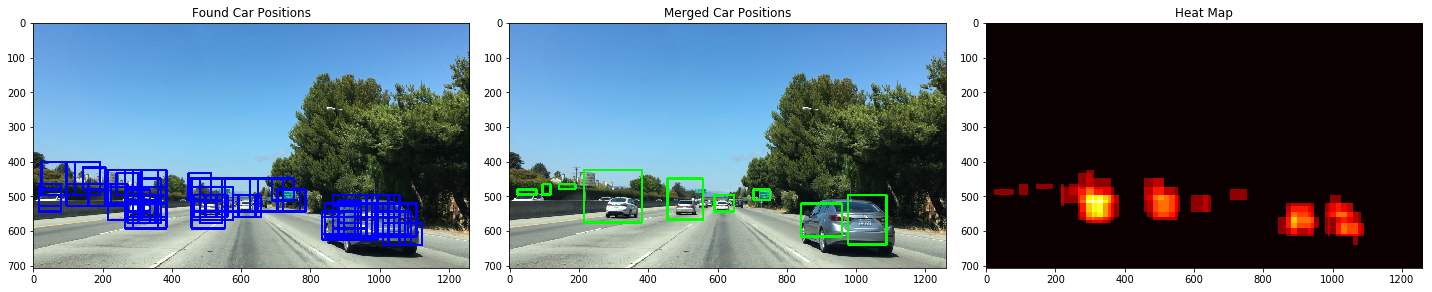

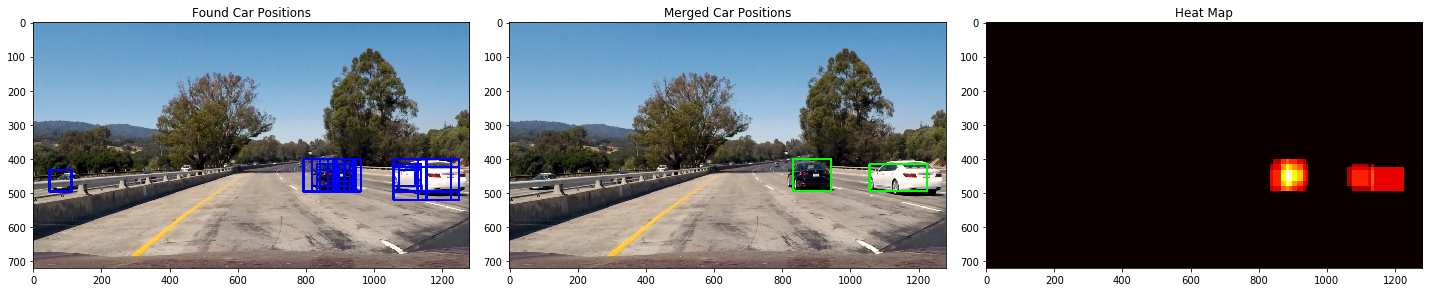

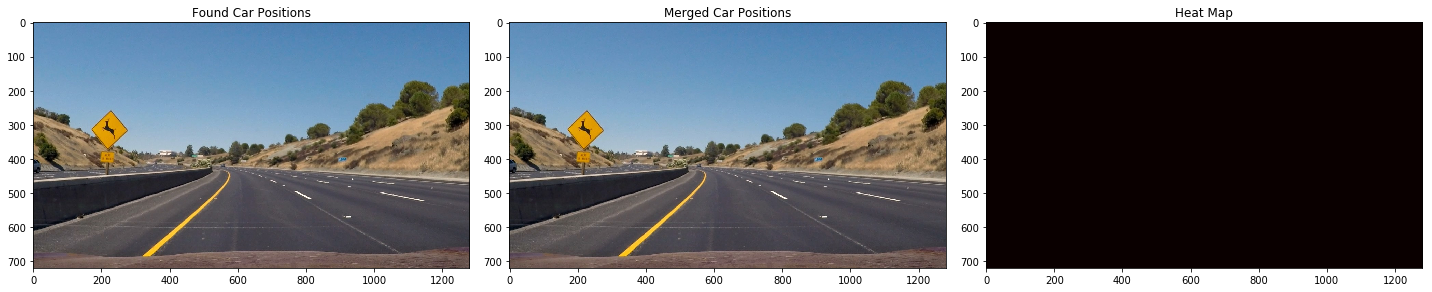

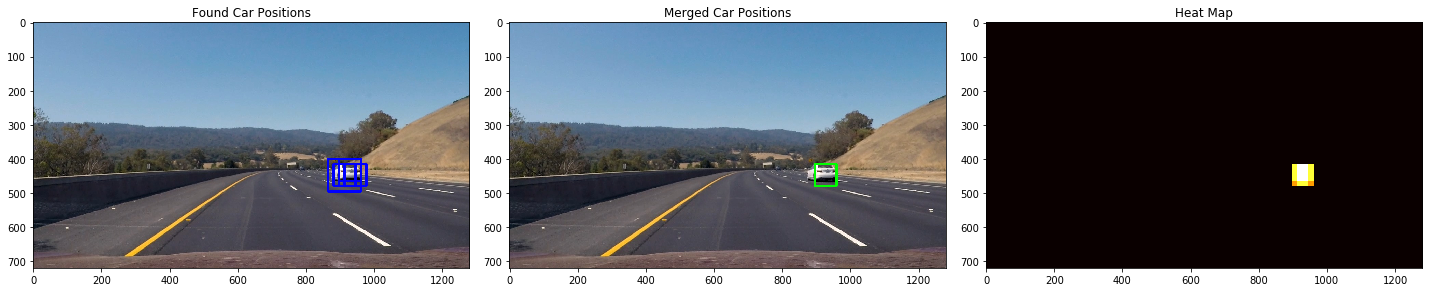

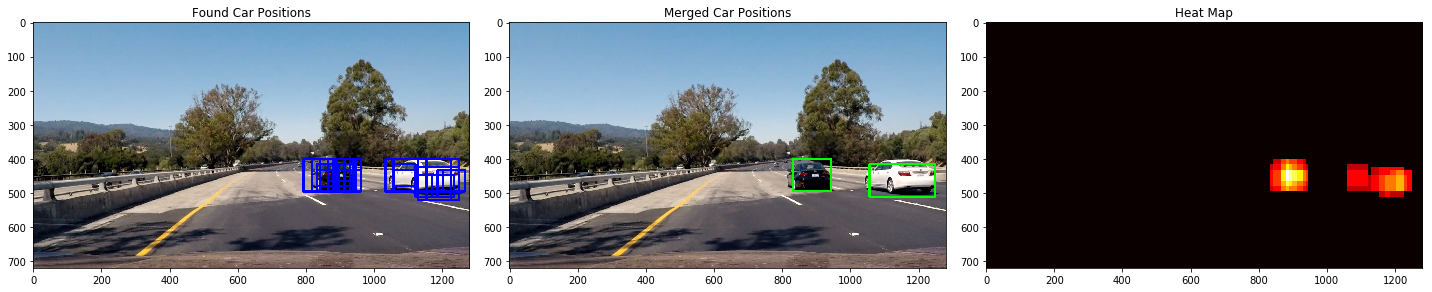

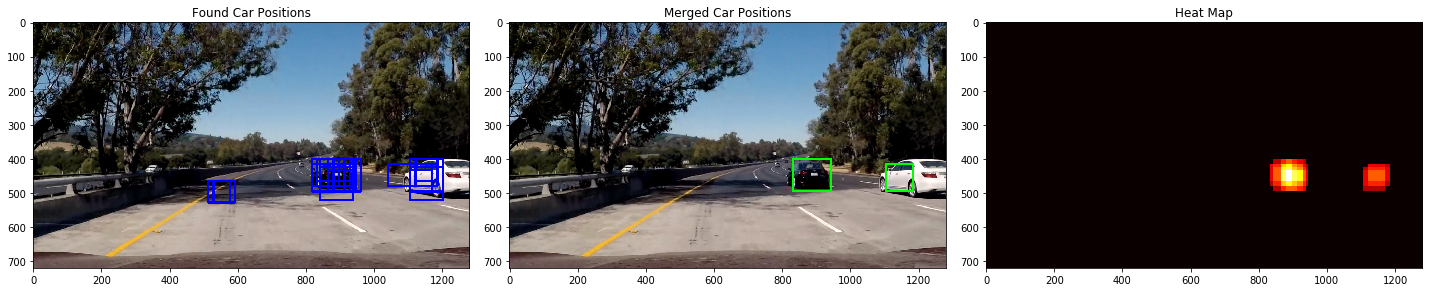

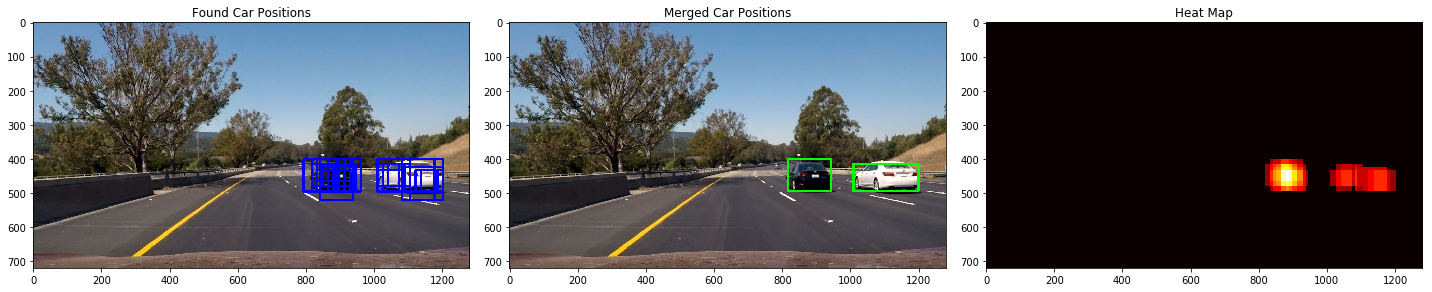

In [14]:
ystart = 400
ystop = 656
scale = 1 # 1.5
treshhold = 2
#scales = [0.5, 1, 1.5, 2.0]
scales = [1, 1.5]

for img_path in glob.glob("test_images/*.jpg"):
    img = cv2.imread(img_path)
     
    box_list = []
    for scale in scales:
        boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        box_list.extend(boxes)
    
    window_img = draw_boxes(img, box_list, color=(255, 0, 0), thick=6)
    window_img = cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)
    
    labels, heatmap = get_heat_map(img, box_list, treshhold)
    draw_img = draw_labeled_bboxes(img, labels)
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
    ax[0].imshow(window_img)
    ax[0].set_title('Found Car Positions')
    ax[1].imshow(draw_img)
    ax[1].set_title('Merged Car Positions')
    ax[2].imshow(heatmap, cmap='hot')
    ax[2].set_title('Heat Map')
    fig.tight_layout()
    
    

In [10]:

ystart = 400
ystop = 656
max_detections = 10
#scales = [0.5, 0,8, 1, 1.5, 2.0]
scales = [1, 1.5]
num_images_to_merge = 5
threshold = num_images_to_merge * 4 # should have at least 2 detections per image on average


class Detections:
    def __init__(self):
        self.image_count = 0
        self.heatmaps = deque(maxlen=num_images_to_merge)
        
detections = Detections()


def process_image(img):
    box_list = []
    for scale in scales:
        boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        box_list.extend(boxes)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    add_heat(heatmap, box_list)
    detections.heatmaps.append(heatmap)
    
    combined_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for hm in detections.heatmaps:
        combined_heatmap += hm
        
    apply_threshold(combined_heatmap, threshold)
    combined_heatmap = np.clip(combined_heatmap, 0, 255)
    labels = label(combined_heatmap)
    img = draw_labeled_bboxes(img, labels)
        
    detections.image_count += 1
    
    return img

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
detections = Detections()
video_output = 'output_images/test_video_out.mp4'
clip = VideoFileClip('test_video.mp4') #.subclip(0,2)
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_out.mp4
[MoviePy] Writing video output_images/test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:41<00:01,  1.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_out.mp4 

Wall time: 41.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [12]:
detections = Detections()
video_output = 'output_images/project_video_out.mp4'
clip = VideoFileClip('project_video.mp4') #.subclip(0,5)
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_out.mp4
[MoviePy] Writing video output_images/project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:37<00:01,  1.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_out.mp4 

Wall time: 22min 37s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))